In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e4/sample_submission.csv
/kaggle/input/playground-series-s4e4/train.csv
/kaggle/input/playground-series-s4e4/test.csv
/kaggle/input/abalone-dataset/abalone.csv


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import mean_squared_log_error

import optuna

In [3]:
train  = pd.read_csv('/kaggle/input/playground-series-s4e4/train.csv')
orginal = pd.read_csv('/kaggle/input/abalone-dataset/abalone.csv')
test  = pd.read_csv('/kaggle/input/playground-series-s4e4/test.csv')
submission = pd.read_csv('/kaggle/input/playground-series-s4e4/sample_submission.csv')

In [4]:
train

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9
...,...,...,...,...,...,...,...,...,...,...
90610,90610,M,0.335,0.235,0.075,0.1585,0.0685,0.0370,0.0450,6
90611,90611,M,0.555,0.425,0.150,0.8790,0.3865,0.1815,0.2400,9
90612,90612,I,0.435,0.330,0.095,0.3215,0.1510,0.0785,0.0815,6
90613,90613,I,0.345,0.270,0.075,0.2000,0.0980,0.0490,0.0700,6


In [5]:
# Concatenate train, original, and test dataframes
# train, original, test データフレームを結合
train = train.drop(['id'], axis = 1)
train.columns = orginal.columns
train = pd.concat([train, orginal], ignore_index=True).reset_index().rename(columns={'index':'id'})
test.columns = train.columns[:-1] 
combined = pd.concat([train, test])

# Perform one-hot encoding on the 'Sex' column and add a prefix
# 'Sex'カラムに対してワンホットエンコーディングを実行し、プレフィックスを付加
combined_dummies = pd.get_dummies(combined['Sex'], prefix='Sex', drop_first=False)
combined = pd.concat([combined, combined_dummies], axis=1)

# Re-split the combined dataset into training and testing datasets
# 結合したデータセットを訓練データとテストデータに再分割
train = combined.iloc[:len(train)]
test = combined.iloc[len(train):]

combined

,id,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Sex_F,Sex_I,Sex_M
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11.0,True,False,False
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11.0,True,False,False
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6.0,False,True,False
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10.0,False,False,True
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9.0,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60406,151021,I,0.345,0.260,0.085,0.1775,0.0735,0.0265,0.0500,NaN,False,True,False
60407,151022,F,0.525,0.410,0.145,0.8445,0.3885,0.1670,0.2050,NaN,True,False,False
60408,151023,I,0.590,0.440,0.155,1.1220,0.3930,0.2000,0.2650,NaN,False,True,False
60409,151024,F,0.660,0.525,0.190,1.4935,0.5885,0.3575,0.4350,NaN,True,False,False


In [6]:
train

,id,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Sex_F,Sex_I,Sex_M
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11.0,True,False,False
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11.0,True,False,False
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6.0,False,True,False
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10.0,False,False,True
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9.0,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
94787,94787,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11.0,True,False,False
94788,94788,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10.0,False,False,True
94789,94789,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9.0,False,False,True
94790,94790,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10.0,True,False,False


In [7]:
test

,id,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Sex_F,Sex_I,Sex_M
0,90615,M,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005,NaN,False,False,True
1,90616,M,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750,NaN,False,False,True
2,90617,M,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405,NaN,False,False,True
3,90618,M,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350,NaN,False,False,True
4,90619,I,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050,NaN,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60406,151021,I,0.345,0.260,0.085,0.1775,0.0735,0.0265,0.0500,NaN,False,True,False
60407,151022,F,0.525,0.410,0.145,0.8445,0.3885,0.1670,0.2050,NaN,True,False,False
60408,151023,I,0.590,0.440,0.155,1.1220,0.3930,0.2000,0.2650,NaN,False,True,False
60409,151024,F,0.660,0.525,0.190,1.4935,0.5885,0.3575,0.4350,NaN,True,False,False


# EDA

In [8]:
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values
    summ['%missing'] = df.isnull().sum().values / len(df) * 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['count'] = desc['count'].values
    summ['mean'] = desc['mean'].values
    summ['std'] = desc['std'].values
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['first value'] = df.iloc[0].values
    summ['second value'] = df.iloc[1].values
    summ['third value'] = df.iloc[2].values
    return summ 

In [9]:
summary(train)

data shape: (94792, 13)


,data type,#missing,%missing,#unique,count,mean,std,min,max,first value,second value,third value
id,int64,0,0.0,94792,94792.0,47395.5,27364.237696,0.0,94791.0,0,1,2
Sex,object,0,0.0,3,94792,NaN,NaN,NaN,NaN,F,F,I
Length,float64,0,0.0,157,94792.0,0.517402,0.118308,0.075,0.815,0.55,0.63,0.16
Diameter,float64,0,0.0,126,94792.0,0.401952,0.098088,0.055,0.65,0.43,0.49,0.11
Height,float64,0,0.0,90,94792.0,0.135643,0.038193,0.0,1.13,0.15,0.145,0.025
Whole weight,float64,0,0.0,3205,94792.0,0.790785,0.459231,0.002,2.8255,0.7715,1.13,0.021
Shucked weight,float64,0,0.0,1806,94792.0,0.341597,0.205267,0.001,1.488,0.3285,0.458,0.0055
Viscera weight,float64,0,0.0,983,94792.0,0.169914,0.101334,0.0005,0.76,0.1465,0.2765,0.003
Shell weight,float64,0,0.0,1132,94792.0,0.226468,0.130639,0.0015,1.005,0.24,0.32,0.005
Rings,float64,0,0.0,28,94792.0,9.707233,3.178704,1.0,29.0,11.0,11.0,6.0


In [10]:
summary(test)

data shape: (60411, 13)


,data type,#missing,%missing,#unique,count,mean,std,min,max,first value,second value,third value
id,int64,0,0.0,60411,60411.0,120820.0,17439.297893,90615.0,151025.0,90615,90616,90617
Sex,object,0,0.0,3,60411,NaN,NaN,NaN,NaN,M,M,M
Length,float64,0,0.0,148,60411.0,0.517428,0.117609,0.075,0.8,0.645,0.58,0.56
Diameter,float64,0,0.0,130,60411.0,0.401961,0.09747,0.055,0.65,0.475,0.46,0.42
Height,float64,0,0.0,85,60411.0,0.135751,0.038175,0.0,1.095,0.155,0.16,0.14
Whole weight,float64,0,0.0,3037,60411.0,0.790062,0.457591,0.002,2.8255,1.238,0.983,0.8395
Shucked weight,float64,0,0.0,1747,60411.0,0.341227,0.204221,0.001,1.488,0.6185,0.4785,0.3525
Viscera weight,float64,0,0.0,960,60411.0,0.169419,0.10072,0.0005,0.6415,0.3125,0.2195,0.1845
Shell weight,float64,0,0.0,1089,60411.0,0.226125,0.129826,0.0015,1.004,0.3005,0.275,0.2405
Rings,float64,60411,100.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


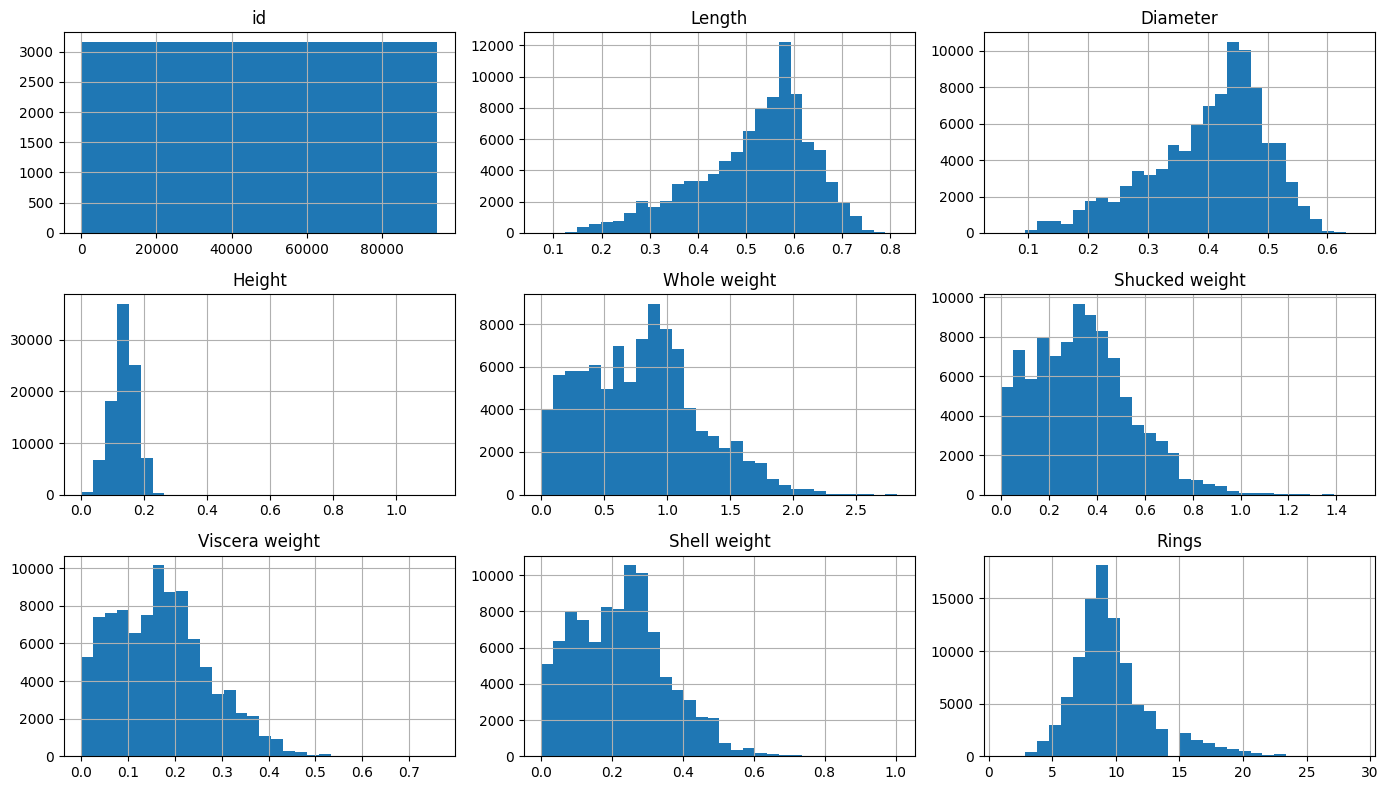

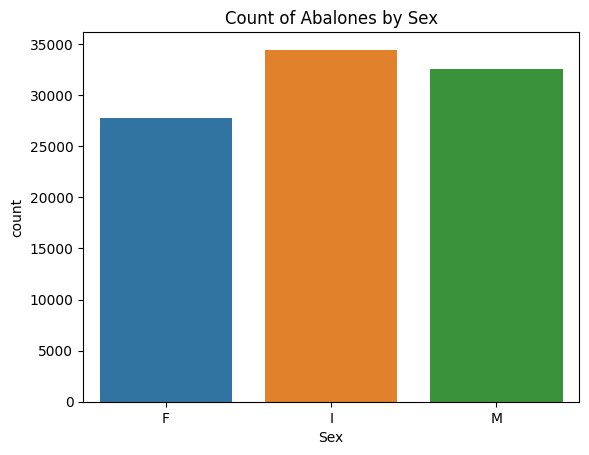

In [11]:
# Using the .hist() method for a quick overview of all numerical distributions in the dataframe
# データフレーム内のすべての数値分布の概要を確認するために .hist() メソッドを使用します
train.hist(figsize=(14, 8), bins=30)
plt.tight_layout()
plt.show()

# Creating a count plot for the 'Sex' category variable in the dataframe
# データフレーム内の 'Sex' カテゴリ変数のカウントプロットを作成します
sns.countplot(x='Sex', data=train)
plt.title('Count of Abalones by Sex')
plt.show()




* Many features exhibit right-skewness: Features such as Length, Diameter, Height, among others, show distributions with long tails to the right, indicating that data are concentrated at lower values.
* The distribution of Rings is particularly noteworthy: Rings, which indicate age, are also right-skewed, revealing that a majority of abalones are relatively young, although there are individuals that reach higher ages.
* Range and variance of the data: Histograms for each feature reveal that the range and variance of the data vary significantly across features. Notably, features related to Whole weight exhibit large variances.
* 
* 多くの特徴量が右に歪んでいます：Length, Diameter, Height, など多数の特徴量が右側に長い尾を持つ分布を示しており、低い値にデータが集中しています。
* Ringsの分布は特に注目に値します：年齢を示すRingsも右に歪んでおり、大多数のあわびが比較的若いことがわかりますが、高年齢に達する個体も存在します。
* データの範囲と分散：各特徴量のヒストグラムからは、データの範囲と分散が特徴量によって大きく異なることが確認できます。特にWhole weight関連の特徴量では分散が大きいことが示されています。

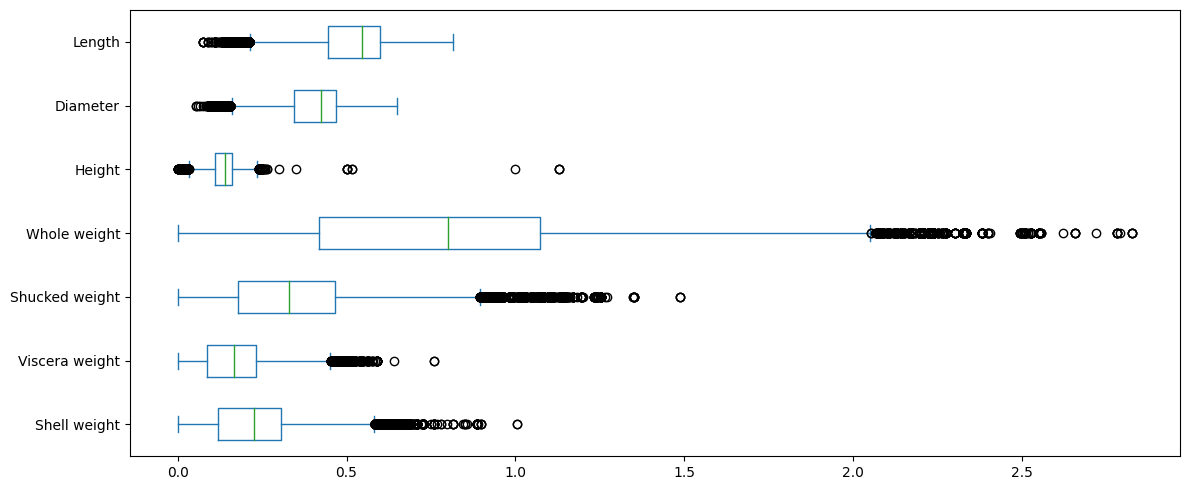

In [12]:
# Specifying the column order to reverse the vertical order of the boxplots
# ボックスプロットの垂直方向の順序を逆転させるために、列の順序を指定します
columns_reversed = train.drop(['id', 'Sex', 'Rings'], axis=1).columns[::-1]

train[columns_reversed].plot(kind='box', figsize=(12, 5), vert=False)
plt.tight_layout()
plt.show()

* Outliers: Many features contain outliers, especially notable in Height. These require consideration during data analysis.
* Concentration of data: Compared to other features, data in Height is more concentrated, while features such as Whole weight exhibit greater variability.
* Skewness of distribution: Many features are right-skewed, indicating a tendency for a large number of data points to have lower values.
* 
* 外れ値: 多くの特徴量に外れ値が存在し、特にHeightで顕著です。これらはデータ分析時に考慮が必要です。
* データの集中度: Heightは他の特徴量に比べてデータが集中しており、Whole weightなどはデータのばらつきが大きいことがわかります。
* 分布の歪み: 多くの特徴量が右に歪んだ分布をしており、低い値のデータ点が多い傾向にあります。

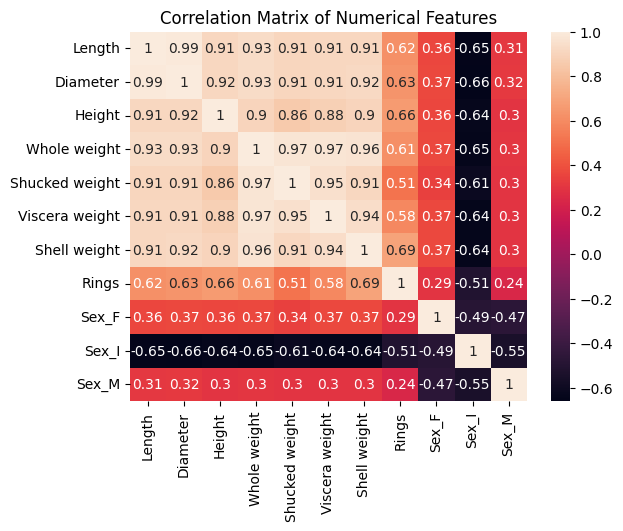

In [13]:
# Correlation matrix for the numerical features
# 数値特徴の相関行列
correlation_matrix = train.drop(['id', 'Sex'], axis=1).corr()

# Heatmap of the correlation matrix
# 相関行列のヒートマップ
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

numeric_features ['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']


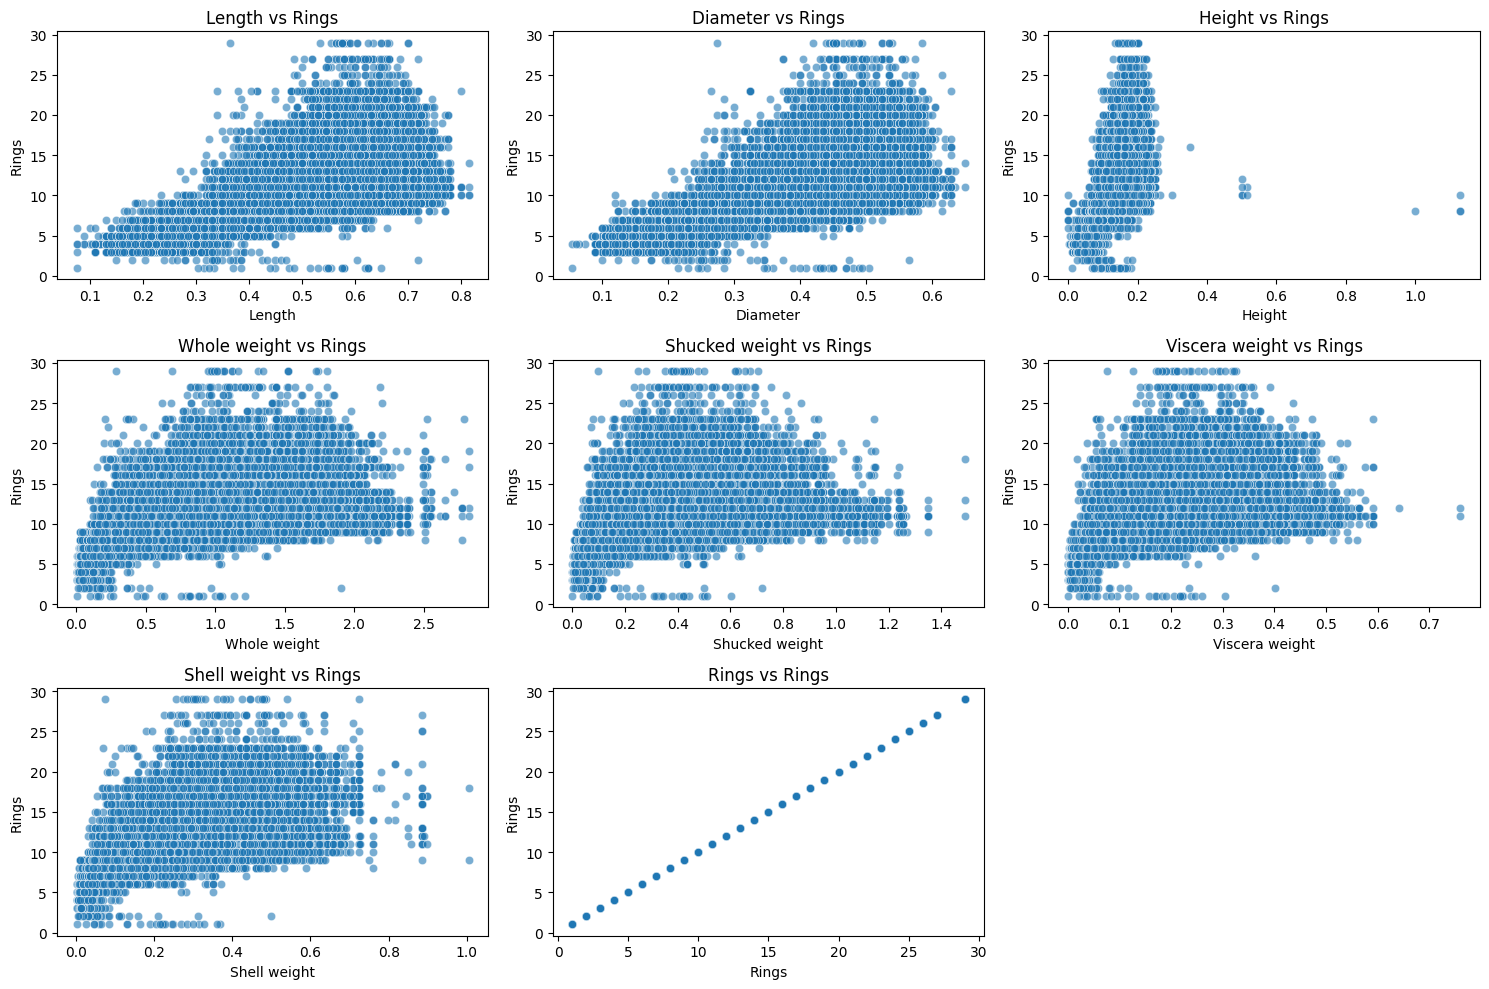

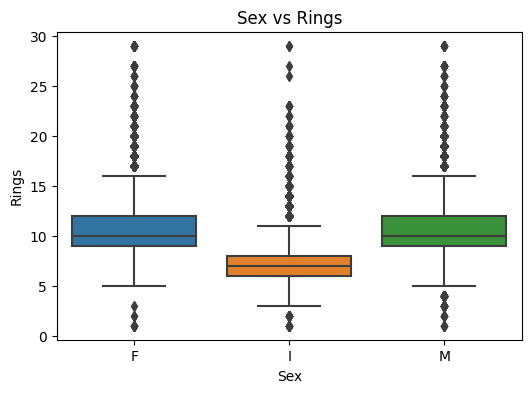

In [14]:
# Visualizing the relationship between numerical data and the target variable (Rings)
# 数値データと目的変数（Rings）の関係を可視化
numeric_features = train.select_dtypes(include=['number']).columns.tolist()[1:]
print('numeric_features',numeric_features)

plt.figure(figsize=(15, 10))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(3, 3, i)
    sns.scatterplot(data=train, x=feature, y='Rings', alpha=0.6)
    plt.title(f'{feature} vs Rings')

plt.tight_layout()
plt.show()

# Visualizing the relationship between the category 'Sex' and the target variable (Rings) with a box plot
# 性別（Sex）と目的変数（Rings）の関係を箱ひげ図で可視化
plt.figure(figsize=(6, 4))
sns.boxplot(data=train, x='Sex', y='Rings')
plt.title('Sex vs Rings')
plt.show()




/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


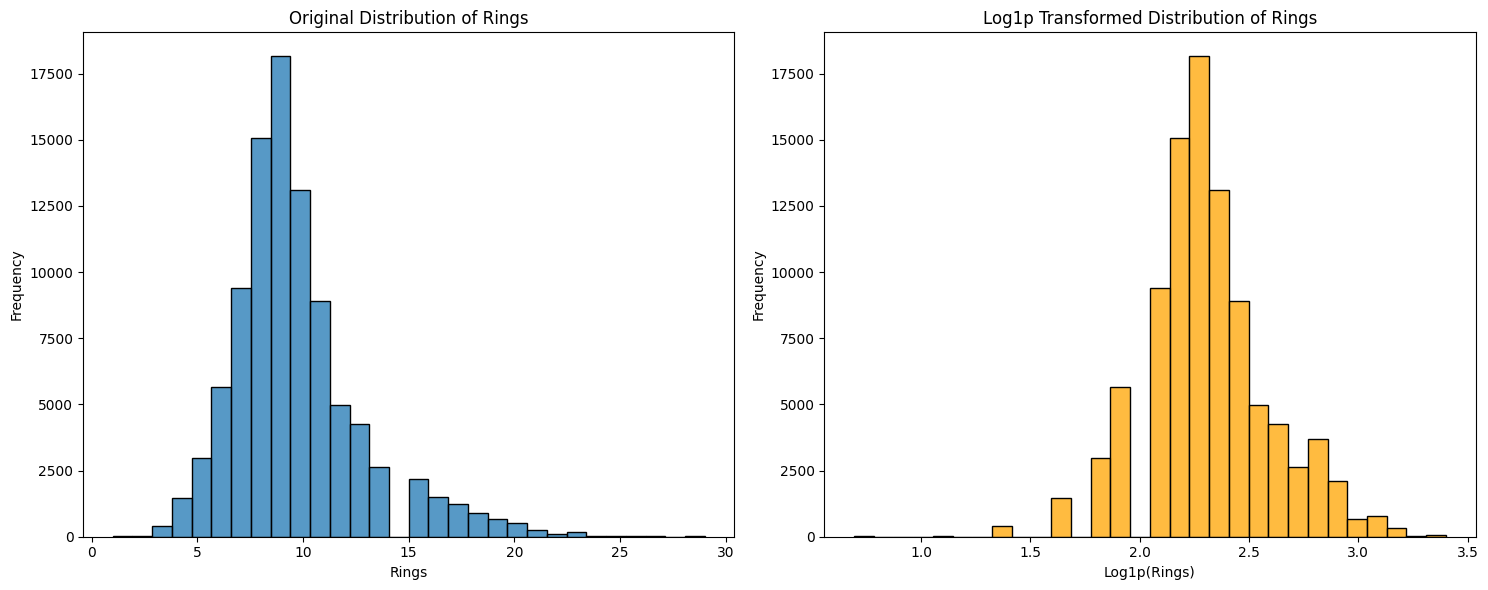

In [15]:
# Display original and log-transformed distributions side by side
# 元の分布と対数変換後の分布を並べて表示
plt.figure(figsize=(15, 6))

# Original distribution
# 元の分布
plt.subplot(1, 2, 1)
sns.histplot(train['Rings'], bins=30, kde=False)
plt.title('Original Distribution of Rings')
plt.xlabel('Rings')
plt.ylabel('Frequency')

# Distribution after log transformation
# 対数変換後の分布
plt.subplot(1, 2, 2)
sns.histplot(np.log1p(train['Rings']), bins=30, kde=False, color='orange')
plt.title('Log1p Transformed Distribution of Rings')
plt.xlabel('Log1p(Rings)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Feature Engineering

In [16]:
def add_features(df):
    """
    Add new features to an abalone dataset DataFrame.
    新しい特徴量をあわびのデータセットのDataFrameに追加する関数。
    """
    #Volume estimation (体積推定値)
    #df['Volume'] = df['Length'] * df['Diameter'] * df['Height']
    
    #Density (体積比重)
    #df['Density'] = df['Whole weight'] / df['Volume']
    
    #Shell weight ratio (殻の重さ比率)
    #df['Shell weight ratio'] = df['Shell weight'] / df['Whole weight']
    #df["Whole weight Ratio"]=df["Whole weight.1"]/df["Whole weight"]
    df["Whole weight Ratio"]=df["Shucked weight"]/df["Whole weight"]
    
    #Sex numeric conversion (性別の数値化)
    #df['Sex_numeric'] = df['Sex'].map({'M': 1, 'F': 2, 'I': 0})
    df['Sex'] = df['Sex'].astype('category')
    
#     columns_to_transform = ['Height', 'Whole weight'] #, 'Whole weight.1','Whole weight.2','Shell weight']
#     df[columns_to_transform] = df[columns_to_transform].apply(np.log1p)
    
    return df


df_train = add_features(train.copy())
df_test = add_features(test.copy())


In [17]:
df_train

,id,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Sex_F,Sex_I,Sex_M,Whole weight Ratio
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11.0,True,False,False,0.425794
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11.0,True,False,False,0.405310
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6.0,False,True,False,0.261905
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10.0,False,False,True,0.410607
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9.0,False,True,False,0.472506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94787,94787,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11.0,True,False,False,0.417136
94788,94788,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10.0,False,False,True,0.454451
94789,94789,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9.0,False,False,True,0.446854
94790,94790,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10.0,True,False,False,0.485153


# Preparation for LightGBM

In [18]:
def rmsle(y_true, y_pred):
    """Calculate RMSLE (Root Mean Squared Logarithmic Error).
    RMSLEの計算。予測値と実際の値の対数の差の二乗平均の平方根を返します。
    """
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

def lgb_rmsle(preds, data):
    """RMSLE evaluation function for LightGBM.
    LightGBM用のRMSLE評価関数。評価結果として('rmsle', value, False)を返します。
    """
    #y_true = data.get_label()
    #return 'rmsle', rmsle(y_true, preds), False

    y_true = data.get_label()  # ここで取得されるy_trueは対数変換後の値です。
    y_true = np.expm1(y_true)  # 対数変換された目的変数を元のスケールに戻します。
    preds = np.expm1(preds)  # 予測値も同様に元のスケールに戻します。
    return 'rmsle', rmsle(y_true, preds), False


    
# Define the target variable and predictors
# 目的変数と説明変数を定義
X_train = df_train.drop(['id', 'Rings','Sex'], axis=1)
y_train = df_train['Rings']
X_test = df_test.drop(['id', 'Rings','Sex'], axis=1)



# Parameter optimization by Optuna

In [19]:
#Parameter optimization by Optuna
#optunaによるパラメータ最適化

# def objective(trial):
#     param = {
#         'objective': 'regression',
#         'metric': 'rmse',
#         'verbosity': -1,
#         'boosting_type': 'gbdt',
#         'random_state': 42,
#         'num_leaves': trial.suggest_int('num_leaves', 20, 300),
#         'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
#         'max_depth': trial.suggest_int('max_depth', 3, 12),
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
#         'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),  
#         'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),  
#         'subsample': trial.suggest_float('subsample', 0.4, 1.0),  
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0)  
#     }
    
#     # KFoldクロスバリデーションの設定
#     #kf = KFold(n_splits=5, shuffle=True, random_state=42)
#     kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#     rmsle_scores = []

#     for train_index, test_index in kf.split(X_train, y_train):
#         X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[test_index]
#         y_train_fold, y_valid_fold = np.log1p(y_train.iloc[train_index]), np.log1p(y_train.iloc[test_index])
        
#         train_data = lgb.Dataset(X_train_fold, label=y_train_fold)
#         valid_data = lgb.Dataset(X_valid_fold, label=y_valid_fold)
        
#         # LightGBMモデルの訓練
#         model = lgb.train(param, 
#                       train_data, 
#                       valid_sets=[valid_data], 
#                       feval=lgb_rmsle,
#                       num_boost_round=trial.suggest_int('n_estimators', 500, 1500),
#                       callbacks=[
#                                 lgb.early_stopping(stopping_rounds=50, verbose=True),
#                                 lgb.log_evaluation(period=500, show_stdv=True)
#                             ])
        
#         preds = model.predict(X_valid_fold, num_iteration=model.best_iteration)
#         preds = np.expm1(preds)  # 予測値を元のスケールに戻す
#         rmsle_score = rmsle(np.expm1(y_valid_fold), preds)
#         rmsle_scores.append(rmsle_score)
        
#     # RMSLEスコアの平均を返す
#     avg_rmsle = np.mean(rmsle_scores)
#     return avg_rmsle

# # Optunaのロガーの設定
# optuna.logging.get_logger("optuna").setLevel(optuna.logging.INFO)

# # Optunaの学習セッションを開始
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)  # 試行回数を設定

# # 最適化されたハイパーパラメータを表示
# print('Number of finished trials:', len(study.trials))
# print('Best trial:', study.best_trial.params)

# # 最適化されたパラメータをparams変数に代入
# optimized_params = study.best_trial.params
# lgb_params = {
#     'objective': 'regression',
#     'metric': 'rmse',
#     'verbosity': -1,
#     'boosting_type': 'gbdt',
#     'random_state': 42,
# }

# lgb_params = {**lgb_params, **optimized_params}
# lgb_params


In [20]:
#Parameters optimized with Optuna
#Optunaで最適化されたバラメータ
lgb_params = {'objective': 'regression',
            'metric': 'rmse',
            'verbosity': -1,
            'boosting_type': 'gbdt',
            'random_state': 42,
            'num_leaves': 101,
            'learning_rate': 0.020164485897084788,
            'max_depth': 11,
            'min_child_samples': 44,
            'reg_alpha': 0.0015998545481907163,
            'reg_lambda': 2.1013623382075584e-05,
            'subsample': 0.9297914833388262,
            'colsample_bytree': 0.4482569076375125,
            'n_estimators': 1241}

# LightGBM Cross-Validation

In [21]:
#kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
feature_importances = pd.DataFrame(columns=['Feature', 'Importance', 'Fold'])

test_predictions = np.zeros(X_test.shape[0])
cv_scores = []

for fold, (train_indices, valid_indices) in enumerate(kf.split(X_train,y_train)): #
    print(f"Training model for Fold {fold+1}")
    X_train_fold, X_valid_fold = X_train.iloc[train_indices], X_train.iloc[valid_indices]
    y_train_fold, y_valid_fold = np.log1p(y_train.iloc[train_indices]), np.log1p(y_train.iloc[valid_indices])
    
    #categorical_features = [] 
    train_data = lgb.Dataset(X_train_fold, label=y_train_fold) #, categorical_feature=categorical_features)
    valid_data = lgb.Dataset(X_valid_fold, label=y_valid_fold) #, categorical_feature=categorical_features)
    
    # Train the model
    model = lgb.train(lgb_params, 
                      train_data, 
                      valid_sets=[valid_data], 
                      feval=lgb_rmsle,
                      num_boost_round=lgb_params['n_estimators'],
                      callbacks=[
                                lgb.early_stopping(stopping_rounds=50, verbose=True),
                                lgb.log_evaluation(period=500, show_stdv=True)
                            ])
    
    fold_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': model.feature_importance(importance_type='gain'),
        'Fold': fold + 1
    })
    feature_importances = pd.concat([feature_importances, fold_importance], axis=0)
    
    # Predict on validation data and calculate RMSLE score
    # 検証データでの予測とRMSLEスコアの計算
    valid_pred = model.predict(X_valid_fold, num_iteration=model.best_iteration)
    valid_pred = np.expm1(valid_pred)  # 予測値を元のスケールに戻します
    cv_score = rmsle(np.expm1(y_valid_fold), valid_pred)  # y_valid_foldも元のスケールに戻す
    cv_scores.append(cv_score)
    print(f"Fold {fold+1} RMSLE: {cv_score}")
    
    # Predict on test data
    # テストデータの予測
    test_pred = np.expm1(model.predict(X_test, num_iteration=model.best_iteration))
    test_predictions += test_pred / kf.n_splits

# Display average RMSLE score across folds
# CVの平均RMSLEスコアの表示
print()
print(f"Average RMSLE across folds: {np.mean(cv_scores)}")

Training model for Fold 1
Training until validation scores don't improve for 50 rounds


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[500]	valid_0's rmse: 0.149047	valid_0's rmsle: 0.149047
[1000]	valid_0's rmse: 0.148651	valid_0's rmsle: 0.148651
Early stopping, best iteration is:
[1092]	valid_0's rmse: 0.148622	valid_0's rmsle: 0.148622


/tmp/ipykernel_19/1562761415.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_importances = pd.concat([feature_importances, fold_importance], axis=0)


Fold 1 RMSLE: 0.14862172038550706
Training model for Fold 2
Training until validation scores don't improve for 50 rounds


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[500]	valid_0's rmse: 0.147618	valid_0's rmsle: 0.147618
[1000]	valid_0's rmse: 0.147275	valid_0's rmsle: 0.147275
Early stopping, best iteration is:
[1119]	valid_0's rmse: 0.147226	valid_0's rmsle: 0.147226
Fold 2 RMSLE: 0.14722569687920192
Training model for Fold 3
Training until validation scores don't improve for 50 rounds


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[500]	valid_0's rmse: 0.148358	valid_0's rmsle: 0.148358
[1000]	valid_0's rmse: 0.14803	valid_0's rmsle: 0.14803
Early stopping, best iteration is:
[959]	valid_0's rmse: 0.148027	valid_0's rmsle: 0.148027
Fold 3 RMSLE: 0.14802681487244396
Training model for Fold 4
Training until validation scores don't improve for 50 rounds


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[500]	valid_0's rmse: 0.149289	valid_0's rmsle: 0.149289
[1000]	valid_0's rmse: 0.148967	valid_0's rmsle: 0.148967
Early stopping, best iteration is:
[1060]	valid_0's rmse: 0.148939	valid_0's rmsle: 0.148939
Fold 4 RMSLE: 0.14893901644479354
Training model for Fold 5
Training until validation scores don't improve for 50 rounds


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[500]	valid_0's rmse: 0.148601	valid_0's rmsle: 0.148601
[1000]	valid_0's rmse: 0.148284	valid_0's rmsle: 0.148284
Early stopping, best iteration is:
[1040]	valid_0's rmse: 0.148273	valid_0's rmsle: 0.148273
Fold 5 RMSLE: 0.14827340330595185

Average RMSLE across folds: 0.14821733037757967


    ver5
    Average RMSLE across folds: 0.14912768453801478

    ver6: Log-transforming the target variable with log1p
    Average RMSLE across folds: 0.14834247277098556
    
    ver7:
    Average RMSLE across folds: 0.1481939846873262
    
    ver8: optuna
    Average RMSLE across folds: 0.14804310287234881
    
    ver9: StratifiedKFold
    Average RMSLE across folds: 0.14795270010106842
    
    ver10: learning_rate=0.01
    Average RMSLE across folds: 0.14784928733958896
    
    ver11: concat(train, orignal),one-hot encoding, optuna stopping_rounds=50
    Average RMSLE across folds: 0.14846738915142882
    
    ver12: optuna n_trials=100
    Average RMSLE across folds: 0.14821733037757967

In [22]:
# Create submission file
# 提出ファイルの作成
submission['Rings'] = test_predictions
submission.to_csv('submission.csv', index=False)
submission

,id,Rings
0,90615,9.801838
1,90616,9.748166
2,90617,9.880017
3,90618,10.577178
4,90619,7.629944
...,...,...
60406,151021,6.273021
60407,151022,9.311759
60408,151023,12.912161
60409,151024,13.536667


# Feature Importances (5-Fold CV)

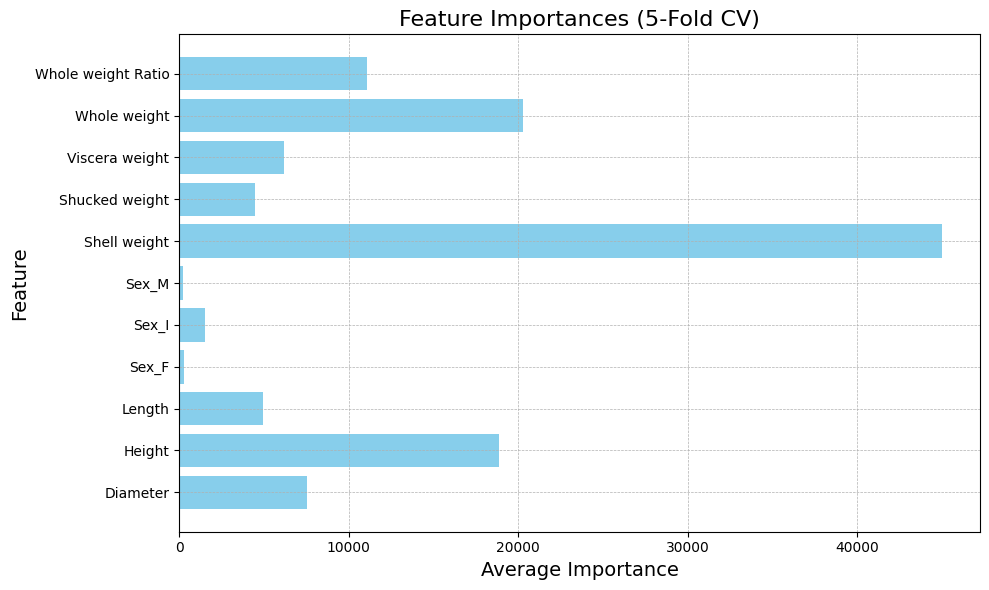

,Feature,Fold1,Fold2,Fold3,Fold4,Fold5,Average
6,Shell weight,45078.862393,44998.488797,44831.806354,44982.600753,45025.982863,44983.548232
9,Whole weight,21795.756324,20402.973742,19923.945891,19517.221253,19748.695769,20277.718596
1,Height,18904.780488,18925.659475,18789.091952,18787.029978,18872.550583,18855.822495
10,Whole weight Ratio,11166.657766,11087.516792,10984.902152,11106.519214,10919.301760,11052.979537
0,Diameter,5853.782867,7608.536428,7921.769358,8376.421711,7839.044100,7519.910893
8,Viscera weight,6236.786842,6038.590021,5950.103917,6326.306798,6271.288778,6164.615271
2,Length,4966.698947,4810.653500,5023.070746,4974.455138,4959.691163,4946.913899
7,Shucked weight,4397.396934,4679.091052,4427.448240,4428.122660,4463.541183,4479.120014
4,Sex_I,1509.977635,1476.237340,1578.941228,1453.592354,1537.468727,1511.243457
3,Sex_F,293.839925,282.504851,288.098463,259.242440,286.534478,282.044031


In [23]:
# Creating the pivot table to cross-tabulate data
# クロス集計の実施、データをクロス集計するためのピボットテーブルを作成
pivot_table = feature_importances.pivot_table(index='Feature', columns='Fold', values='Importance', aggfunc='sum')
pivot_table['Average'] = pivot_table.mean(axis=1)
pivot_table.columns = [f"Fold{col}" if isinstance(col, int) else col for col in pivot_table.columns]
pivot_table.reset_index(inplace=True)

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.barh(pivot_table['Feature'], pivot_table['Average'], color='skyblue')
plt.xlabel('Average Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Feature Importances (5-Fold CV)', fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Sorting the table by 'Average' in descending order
# 「Average」で降順にソート
pivot_table.sort_values(by='Average', ascending=False)